### Data Dictionary

Predict Wins (W)

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("NBA.csv")

In [3]:
df

SeasonEnd                 Team  Playoffs   W   PTS  oppPTS    FG   FGA  \
0         1980        Atlanta Hawks         1  50  8573    8334  3261  7027   
1         1980       Boston Celtics         1  61  9303    8664  3617  7387   
2         1980        Chicago Bulls         0  30  8813    9035  3362  6943   
3         1980  Cleveland Cavaliers         0  37  9360    9332  3811  8041   
4         1980       Denver Nuggets         0  30  8878    9240  3462  7470   
..         ...                  ...       ...  ..   ...     ...   ...   ...   
858       2013     Sacramento Kings         0  28  8219    8619  3086  6904   
859       2013    San Antonio Spurs         1  58  8448    7923  3210  6675   
860       2013      Toronto Raptors         0  34  7971    8092  2979  6685   
861       2013            Utah Jazz         0  43  8038    8045  3046  6710   
862       2013   Washington Wizards         0  29  7644    7852  2910  6693   

       2P   2PA   3P   3PA    FT   FTA   ORB   DRB   AST  STL  BLK   TOV  
0    3248  6952   13    75  2038  2645  1369  2406  1913  782  539  1495  
1    3455  6965  162   422  1907  2449  1227  2457  2198  809  308  1539  
2    3292  6668   70   275  2019  2592  1115  2465  2152  704  392  1684  
3    3775  7854   36   187  1702  2205  1307  2381  2108  764  342  1370  
4    3379  7215   83   255  1871  2539  1311  2524  2079  746  404  1533  
..    ...   ...  ...   ...   ...   ...   ...   ...   ...  ...  ...   ...  
858  2476  5223  610  1681  1437  1869   943  2385  1708  671  342  1199  
859  2547  4911  663  1764  1365  1725   666  2721  2058  695  446  1206  
860  2408  5020  571  1665  1442  1831   871  2426  1765  595  392  1124  
861  2539  5325  507  1385  1439  1883   989  2457  1859  690  515  1210  
862  2365  5198  545  1495  1279  1746   887  2652  1775  598  376  1238  

[863 rows x 20 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SeasonEnd  863 non-null    int64 
 1   Team       863 non-null    object
 2   Playoffs   863 non-null    int64 
 3   W          863 non-null    int64 
 4   PTS        863 non-null    int64 
 5   oppPTS     863 non-null    int64 
 6   FG         863 non-null    int64 
 7   FGA        863 non-null    int64 
 8   2P         863 non-null    int64 
 9   2PA        863 non-null    int64 
 10  3P         863 non-null    int64 
 11  3PA        863 non-null    int64 
 12  FT         863 non-null    int64 
 13  FTA        863 non-null    int64 
 14  ORB        863 non-null    int64 
 15  DRB        863 non-null    int64 
 16  AST        863 non-null    int64 
 17  STL        863 non-null    int64 
 18  BLK        863 non-null    int64 
 19  TOV        863 non-null    int64 
dtypes: int64(19), object(1)
memory u

In [5]:
df.describe(include='all')

SeasonEnd            Team    Playoffs           W           PTS  \
count    863.000000             863  863.000000  863.000000    863.000000   
unique          NaN              38         NaN         NaN           NaN   
top             NaN  Denver Nuggets         NaN         NaN           NaN   
freq            NaN              32         NaN         NaN           NaN   
mean    1996.860950             NaN    0.572422   40.989571   8360.232908   
std        9.561215             NaN    0.495014   12.744268    577.260038   
min     1980.000000             NaN    0.000000   11.000000   6901.000000   
25%     1989.000000             NaN    0.000000   31.000000   7930.500000   
50%     1997.000000             NaN    1.000000   42.000000   8296.000000   
75%     2005.000000             NaN    1.000000   50.500000   8769.000000   
max     2013.000000             NaN    1.000000   72.000000  10371.000000   

              oppPTS           FG          FGA           2P          2PA  \
count     863.000000   863.000000   863.000000   863.000000   863.000000   
unique           NaN          NaN          NaN          NaN          NaN   
top              NaN          NaN          NaN          NaN          NaN   
freq             NaN          NaN          NaN          NaN          NaN   
mean     8360.589803  3195.530707  6868.882966  2867.661645  5928.363847   
std       582.468157   284.366791   396.352970   445.721188   833.547771   
min      6909.000000  2565.000000  5972.000000  1981.000000  4153.000000   
25%      7931.000000  2974.000000  6573.000000  2501.000000  5256.500000   
50%      8342.000000  3144.000000  6825.000000  2695.000000  5674.000000   
75%      8756.000000  3426.500000  7148.000000  3283.500000  6722.000000   
max     10723.000000  3980.000000  8868.000000  3954.000000  7873.000000   

                3P          3PA           FT          FTA          ORB  \
count   863.000000   863.000000   863.000000   863.000000   863.000000   
unique         NaN          NaN          NaN          NaN          NaN   
top            NaN          NaN          NaN          NaN          NaN   
freq           NaN          NaN          NaN          NaN          NaN   
mean    327.869061   940.519119  1641.302433  2177.903824  1056.989571   
std     203.350201   533.732090   202.918046   252.356162   151.087676   
min      10.000000    75.000000  1004.000000  1359.000000   639.000000   
25%     135.500000   428.500000  1493.000000  1994.000000   943.000000   
50%     333.000000   984.000000  1621.000000  2170.000000  1050.000000   
75%     491.000000  1374.000000  1777.000000  2349.500000  1160.500000   
max     891.000000  2371.000000  2388.000000  3051.000000  1520.000000   

                DRB          AST          STL         BLK          TOV  
count    863.000000   863.000000   863.000000  863.000000   863.000000  
unique          NaN          NaN          NaN         NaN          NaN  
top             NaN          NaN          NaN         NaN          NaN  
freq            NaN          NaN          NaN         NaN          NaN  
mean    2430.771727  1909.085747   667.456547  419.793743  1299.221321  
std      131.631693   219.615324    92.778321   81.956890   153.200143  
min     2044.000000  1423.000000   455.000000  204.000000   931.000000  
25%     2349.500000  1735.000000   598.000000  359.000000  1192.000000  
50%     2436.000000  1892.000000   658.000000  410.000000  1280.000000  
75%     2519.500000  2070.500000   727.500000  468.500000  1391.500000  
max     2801.000000  2575.000000  1053.000000  716.000000  1873.000000

In [6]:
df.shape

(863, 20)

In [7]:
df.columns

Index(['SeasonEnd', 'Team', 'Playoffs', 'W', 'PTS', 'oppPTS', 'FG', 'FGA',
       '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'AST', 'STL',
       'BLK', 'TOV'],
      dtype='object')

### Data Visualization

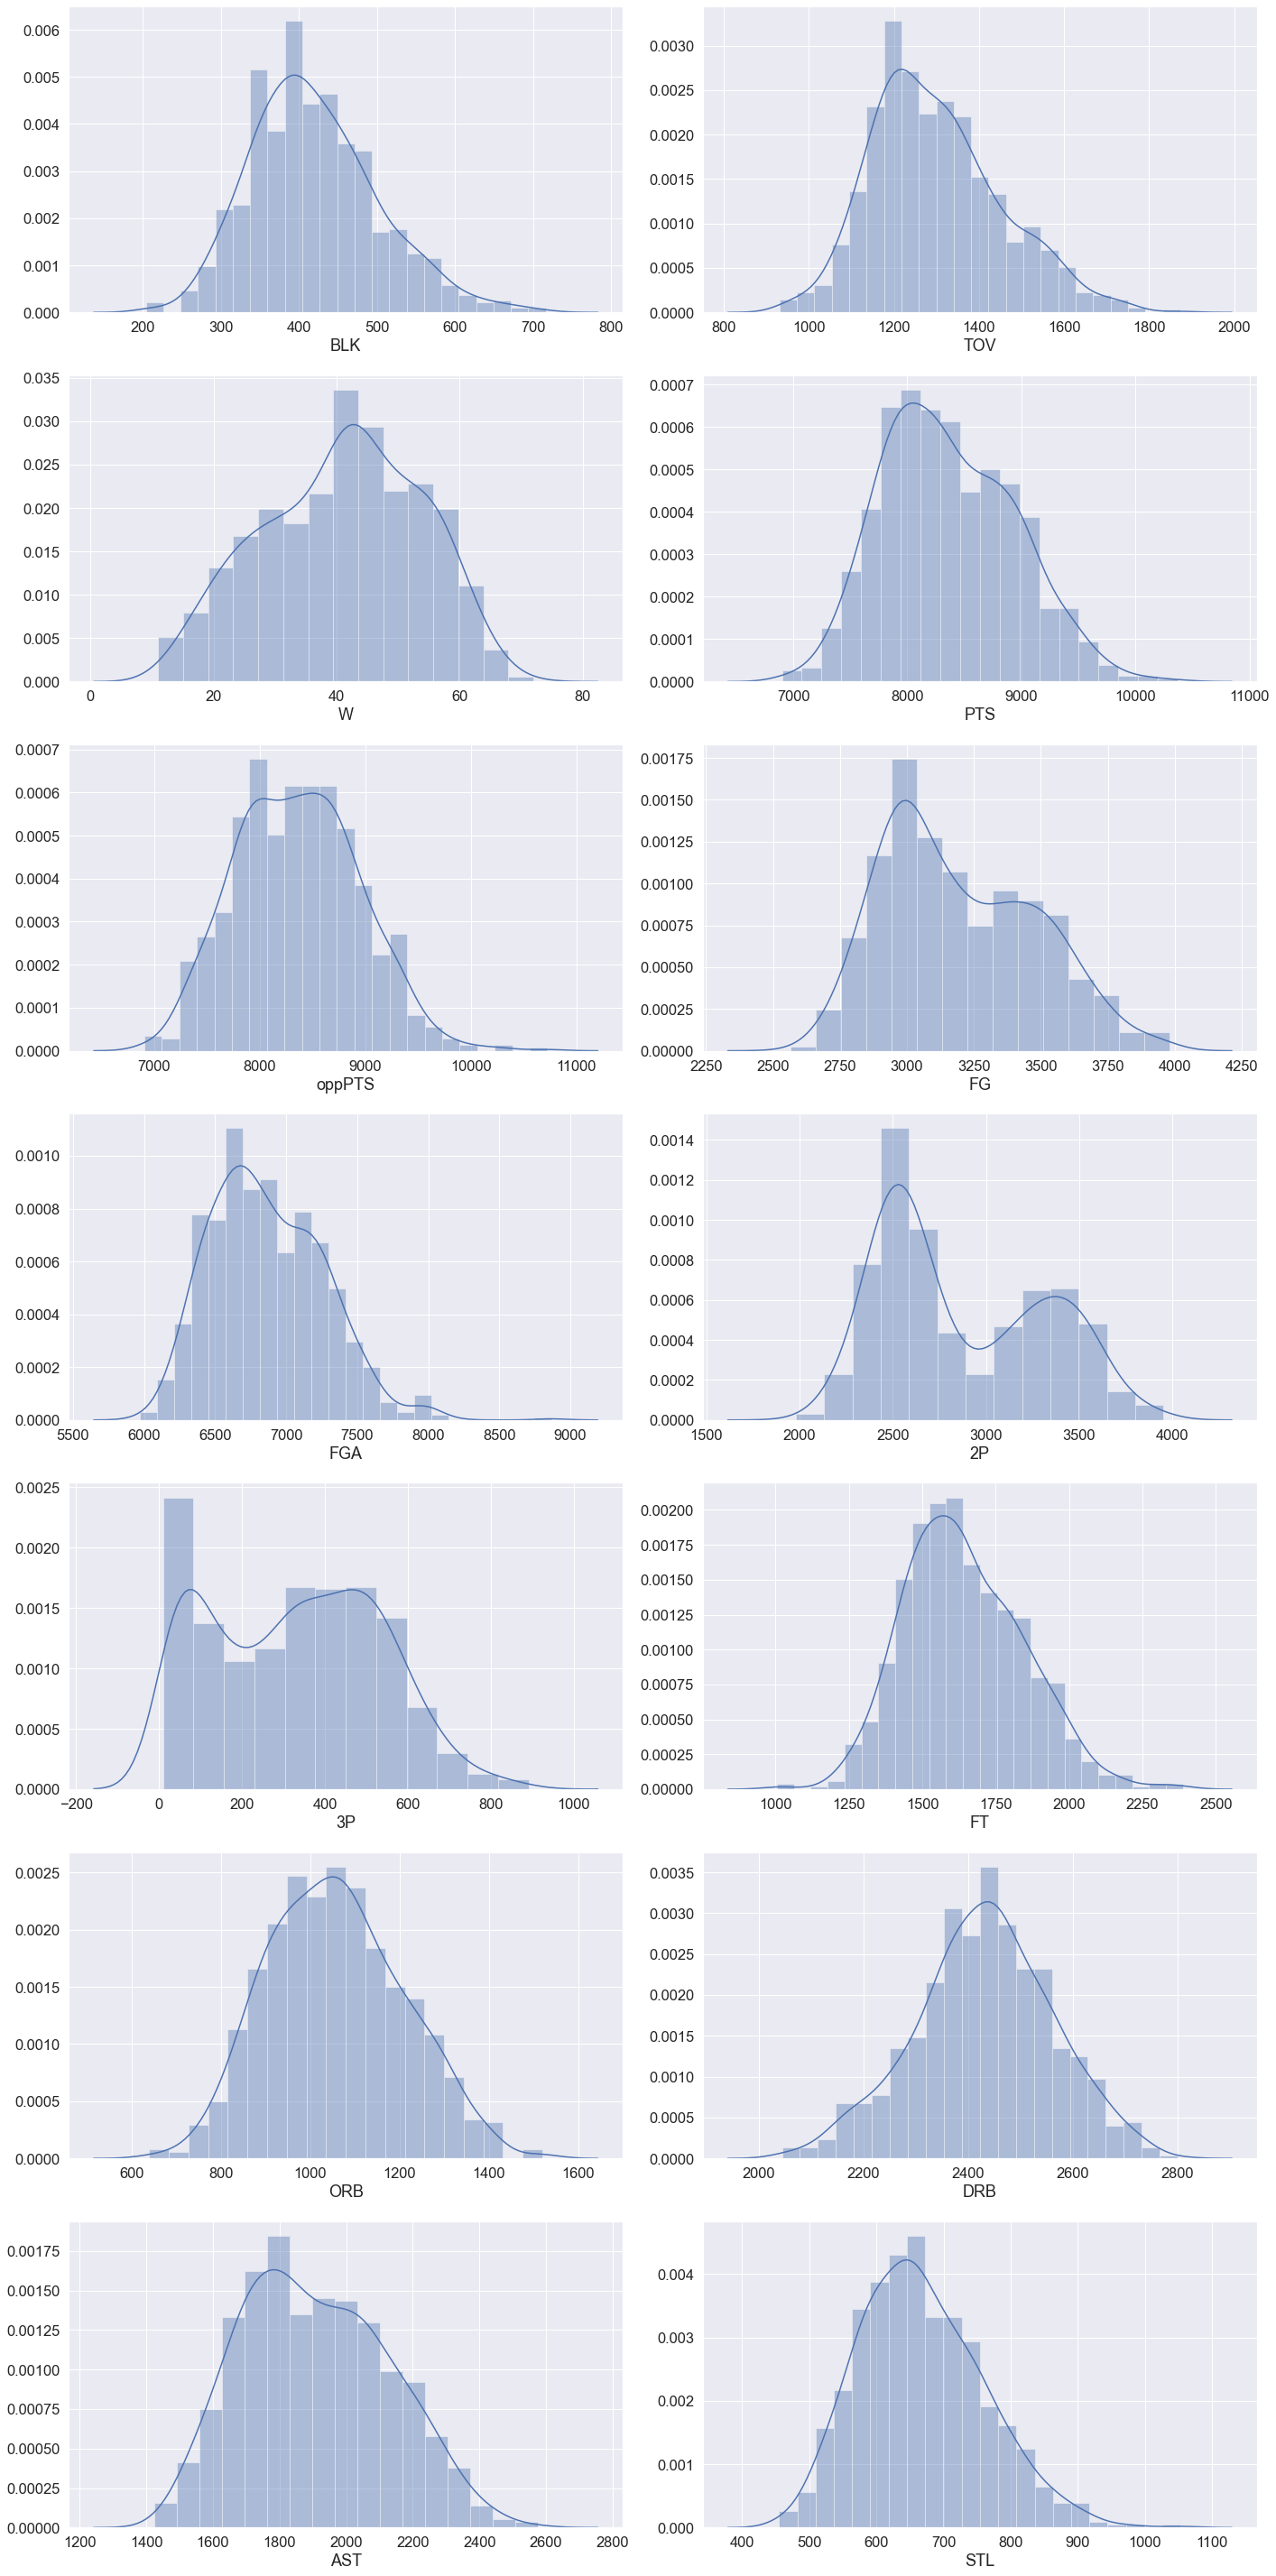

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.distplot(df.BLK)
plt.subplot(7,2,2)
sns.distplot(df.TOV)
plt.subplot(7,2,3)
sns.distplot(df.W)
plt.subplot(7,2,4)
sns.distplot(df.PTS)
plt.subplot(7,2,5)
sns.distplot(df.oppPTS)
plt.subplot(7,2,6)
sns.distplot(df.FG)
plt.subplot(7,2,7)
sns.distplot(df.FGA)
plt.subplot(7,2,8)
sns.distplot(df['2P'])
plt.subplot(7,2,9)
sns.distplot(df['3P'])
plt.subplot(7,2,10)
sns.distplot(df.FT)
plt.subplot(7,2,11)
sns.distplot(df.ORB)
plt.subplot(7,2,12)
sns.distplot(df.DRB)
plt.subplot(7,2,13)
sns.distplot(df.AST)
plt.subplot(7,2,14)
sns.distplot(df.STL)

plt.tight_layout()
plt.show()

In [9]:
df.corr()

SeasonEnd  Playoffs         W       PTS    oppPTS        FG  \
SeasonEnd   1.000000 -0.063559 -0.001383 -0.631425 -0.624744 -0.748194   
Playoffs   -0.063559  1.000000  0.799769  0.276536 -0.231099  0.190562   
W          -0.001383  0.799769  1.000000  0.303732 -0.331505  0.192740   
PTS        -0.631425  0.276536  0.303732  1.000000  0.785839  0.940650   
oppPTS     -0.624744 -0.231099 -0.331505  0.785839  1.000000  0.802517   
FG         -0.748194  0.190562  0.192740  0.940650  0.802517  1.000000   
FGA        -0.667126 -0.012932 -0.075095  0.787795  0.829364  0.876907   
2P         -0.862064  0.108266  0.068442  0.821049  0.767222  0.939581   
2PA        -0.865288 -0.010155 -0.088746  0.700998  0.752708  0.853368   
3P          0.843267  0.029177  0.119511 -0.484235 -0.559420 -0.661048   
3PA         0.855938  0.006255  0.082831 -0.509751 -0.559638 -0.681537   
FT         -0.544317  0.223347  0.204085  0.693631  0.546889  0.535636   
FTA        -0.576313  0.184281  0.162423  0.651456  0.533248  0.518111   
ORB        -0.704304 -0.036713 -0.096869  0.492928  0.550425  0.594691   
DRB         0.291919  0.339979  0.462598  0.082698 -0.217958  0.001102   
AST        -0.657707  0.314316  0.318710  0.757775  0.541048  0.812551   
STL        -0.489268  0.180644  0.127203  0.434565  0.340128  0.471645   
BLK        -0.191967  0.187980  0.207776  0.153791  0.028927  0.177653   
TOV        -0.720409 -0.159266 -0.236381  0.432784  0.585035  0.521545   

                FGA        2P       2PA        3P       3PA        FT  \
SeasonEnd -0.667126 -0.862064 -0.865288  0.843267  0.855938 -0.544317   
Playoffs  -0.012932  0.108266 -0.010155  0.029177  0.006255  0.223347   
W         -0.075095  0.068442 -0.088746  0.119511  0.082831  0.204085   
PTS        0.787795  0.821049  0.700998 -0.484235 -0.509751  0.693631   
oppPTS     0.829364  0.767222  0.752708 -0.559420 -0.559638  0.546889   
FG         0.876907  0.939581  0.853368 -0.661048 -0.681537  0.535636   
FGA        1.000000  0.833153  0.858147 -0.599905 -0.597591  0.384525   
2P         0.833153  1.000000  0.965111 -0.877971 -0.888542  0.582122   
2PA        0.858147  0.965111  1.000000 -0.922060 -0.924469  0.526422   
3P        -0.599905 -0.877971 -0.922060  1.000000  0.994519 -0.526908   
3PA       -0.597591 -0.888542 -0.924469  0.994519  1.000000 -0.536580   
FT         0.384525  0.582122  0.526422 -0.526908 -0.536580  1.000000   
FTA        0.374554  0.581805  0.533521 -0.550722 -0.555073  0.953005   
ORB        0.731574  0.686810  0.769021 -0.673790 -0.657735  0.410718   
DRB       -0.057717 -0.117472 -0.186412  0.259028  0.248265 -0.027411   
AST        0.627433  0.774634  0.673594 -0.561634 -0.586039  0.441146   
STL        0.477244  0.487939  0.484919 -0.409956 -0.402910  0.325161   
BLK        0.118742  0.216250  0.202834 -0.225566 -0.228595  0.165628   
TOV        0.450585  0.643121  0.648546 -0.680317 -0.678249  0.451174   

                FTA       ORB       DRB       AST       STL       BLK  \
SeasonEnd -0.576313 -0.704304  0.291919 -0.657707 -0.489268 -0.191967   
Playoffs   0.184281 -0.036713  0.339979  0.314316  0.180644  0.187980   
W          0.162423 -0.096869  0.462598  0.318710  0.127203  0.207776   
PTS        0.651456  0.492928  0.082698  0.757775  0.434565  0.153791   
oppPTS     0.533248  0.550425 -0.217958  0.541048  0.340128  0.028927   
FG         0.518111  0.594691  0.001102  0.812551  0.471645  0.177653   
FGA        0.374554  0.731574 -0.057717  0.627433  0.477244  0.118742   
2P         0.581805  0.686810 -0.117472  0.774634  0.487939  0.216250   
2PA        0.533521  0.769021 -0.186412  0.673594  0.484919  0.202834   
3P        -0.550722 -0.673790  0.259028 -0.561634 -0.409956 -0.225566   
3PA       -0.555073 -0.657735  0.248265 -0.586039 -0.402910 -0.228595   
FT         0.953005  0.410718 -0.027411  0.441146  0.325161  0.165628   
FTA        1.000000  0.489383 -0.074072  0.422481  0.369707  0.212956   
ORB        0.489383  1.000000 -0.288506  0.4034

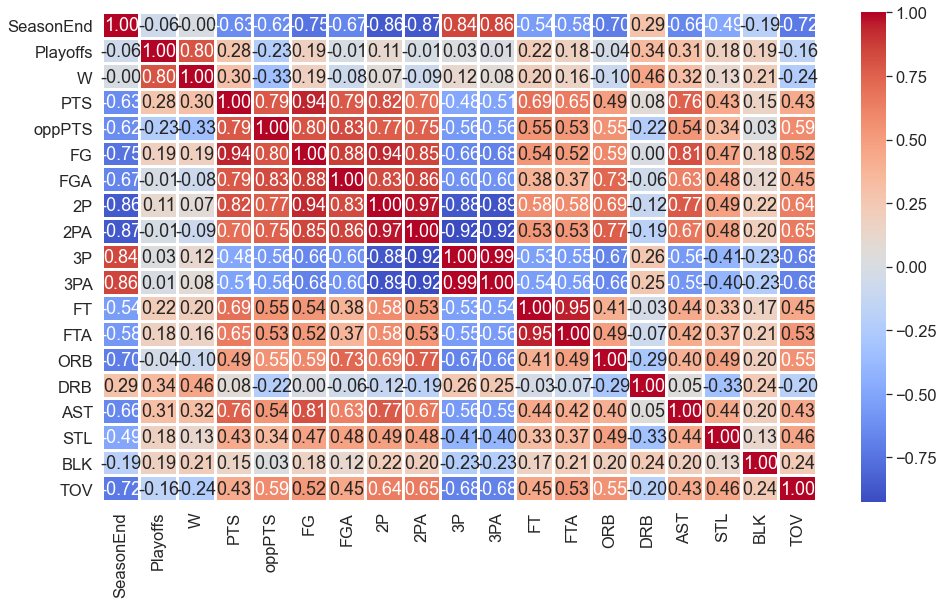

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

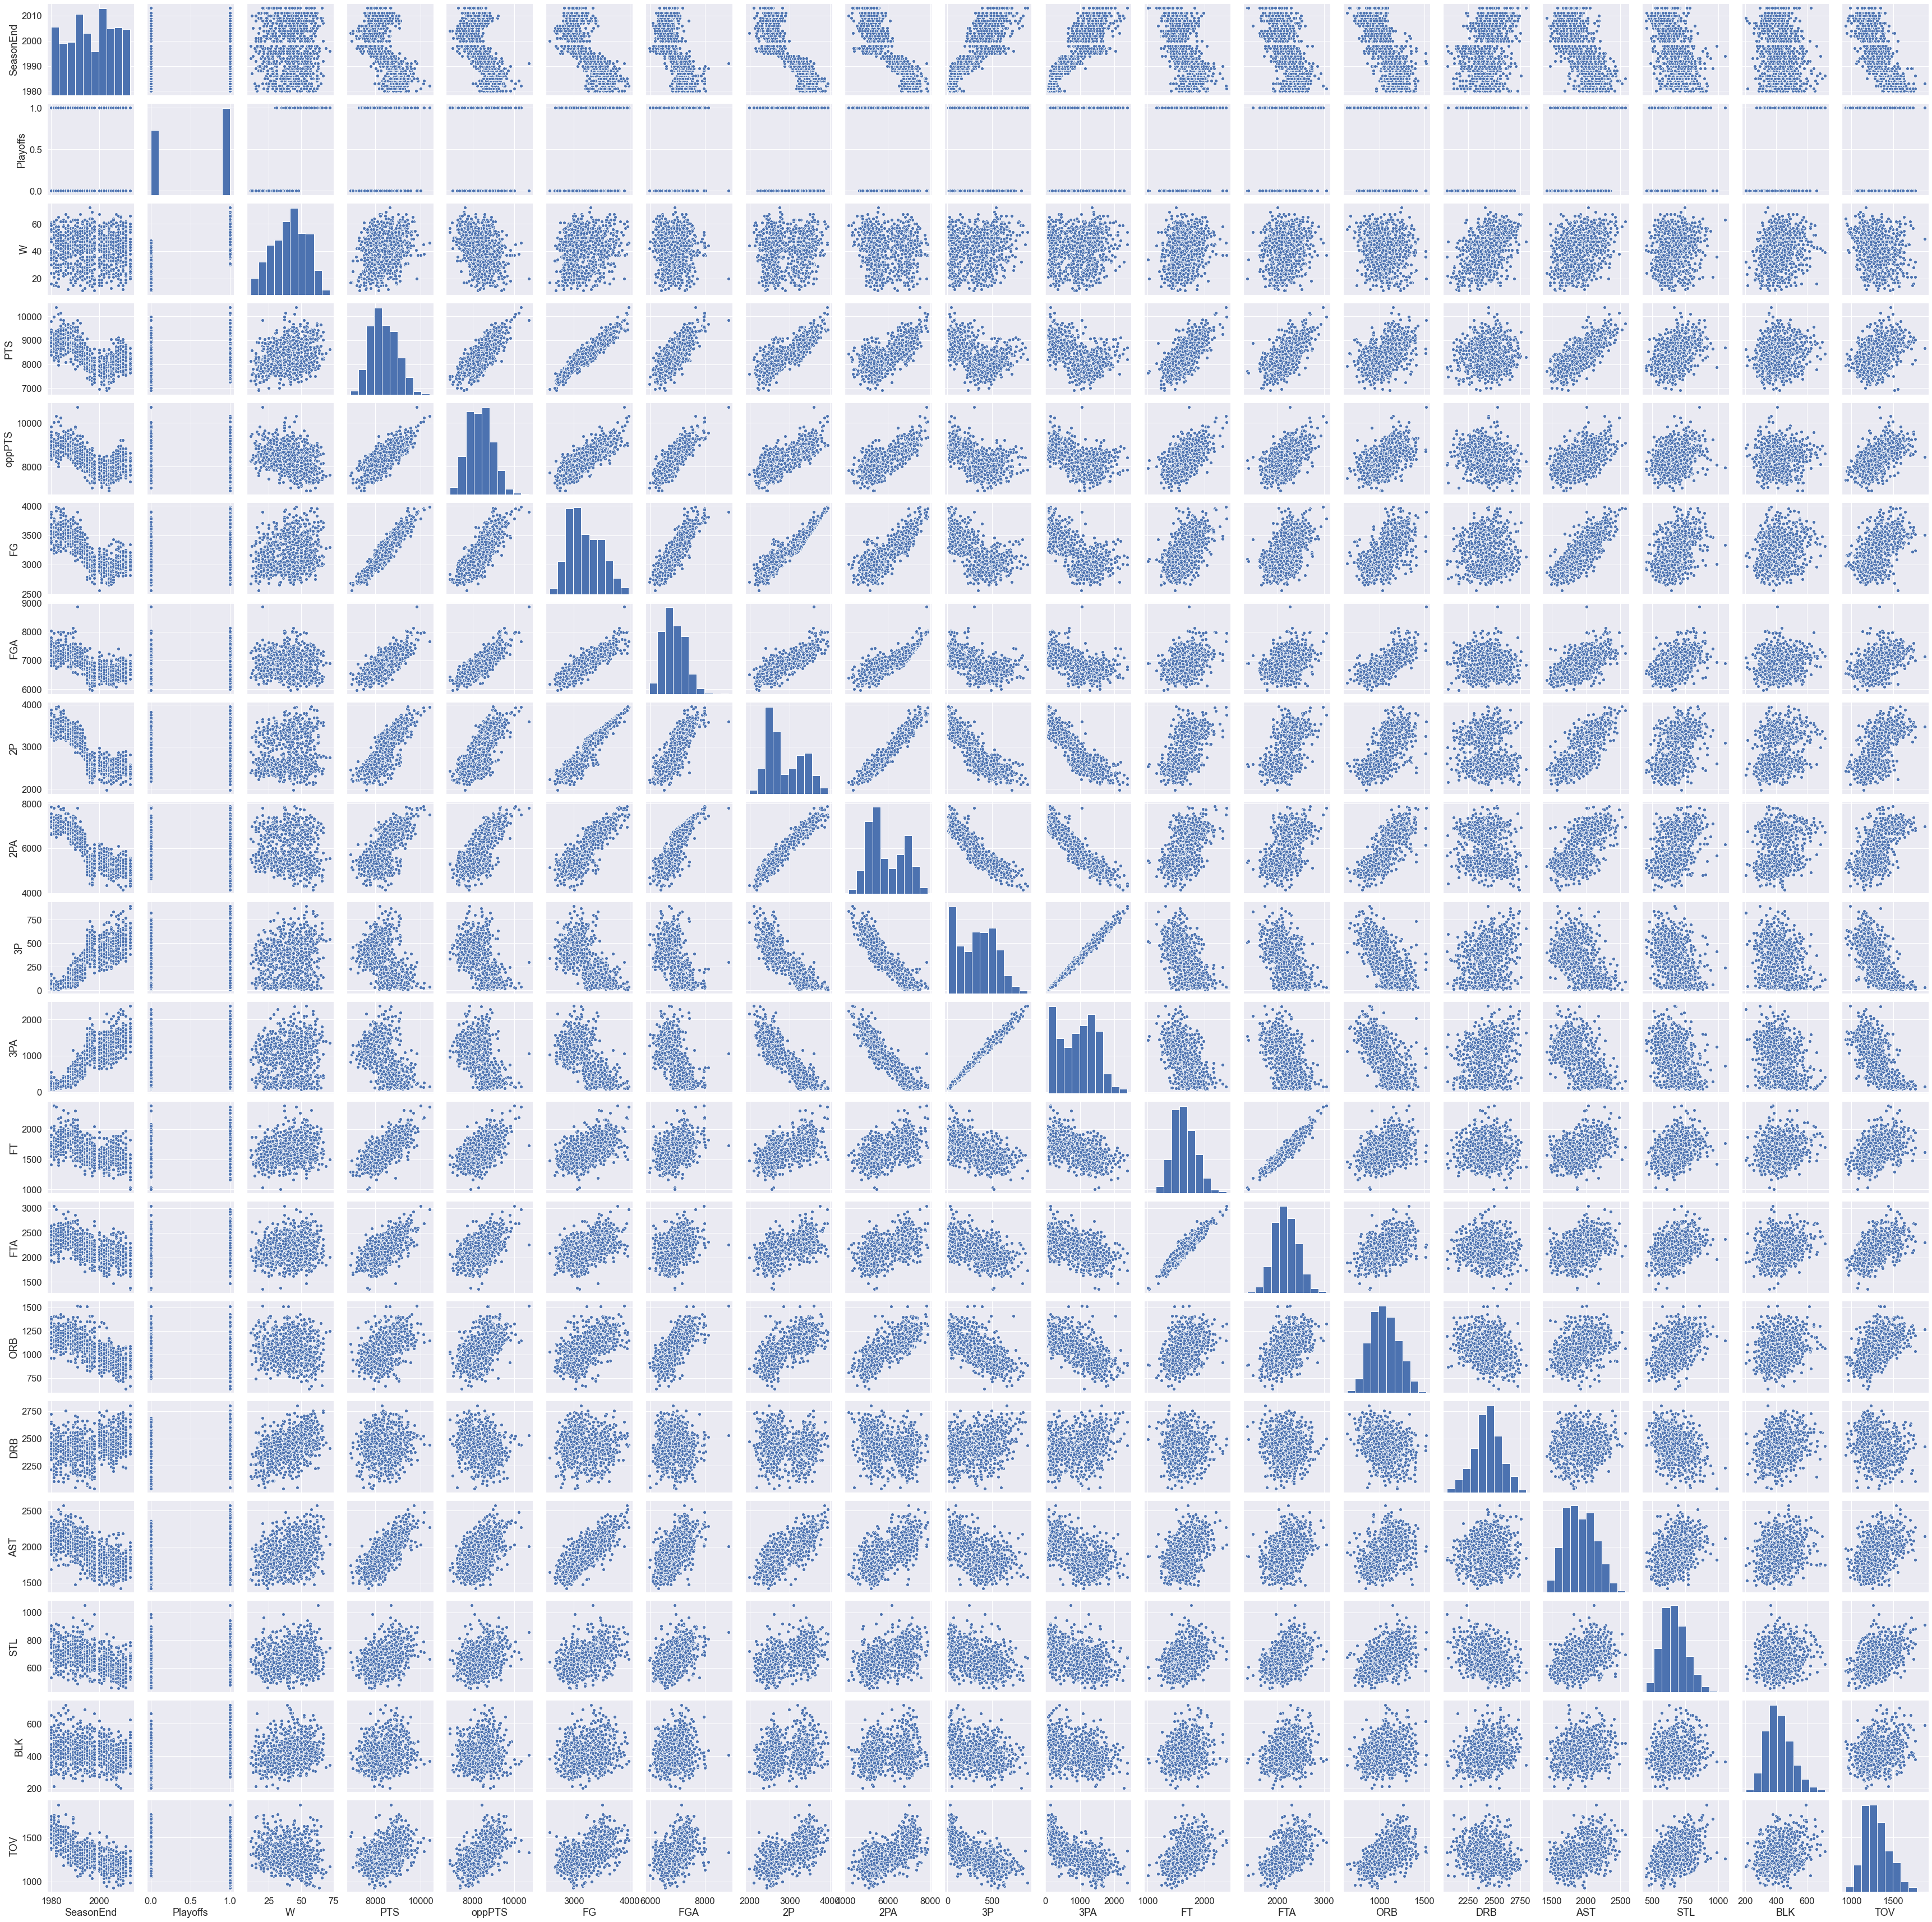

In [11]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

SeasonEnd    0
Team         0
Playoffs     0
W            0
PTS          0
oppPTS       0
FG           0
FGA          0
2P           0
2PA          0
3P           0
3PA          0
FT           0
FTA          0
ORB          0
DRB          0
AST          0
STL          0
BLK          0
TOV          0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

In [14]:
df.columns

Index(['SeasonEnd', 'Team', 'Playoffs', 'W', 'PTS', 'oppPTS', 'FG', 'FGA',
       '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'AST', 'STL',
       'BLK', 'TOV'],
      dtype='object')

In [15]:
df.describe()

SeasonEnd    Playoffs           W           PTS        oppPTS  \
count   863.000000  863.000000  863.000000    863.000000    863.000000   
mean   1996.860950    0.572422   40.989571   8360.232908   8360.589803   
std       9.561215    0.495014   12.744268    577.260038    582.468157   
min    1980.000000    0.000000   11.000000   6901.000000   6909.000000   
25%    1989.000000    0.000000   31.000000   7930.500000   7931.000000   
50%    1997.000000    1.000000   42.000000   8296.000000   8342.000000   
75%    2005.000000    1.000000   50.500000   8769.000000   8756.000000   
max    2013.000000    1.000000   72.000000  10371.000000  10723.000000   

                FG          FGA           2P          2PA          3P  \
count   863.000000   863.000000   863.000000   863.000000  863.000000   
mean   3195.530707  6868.882966  2867.661645  5928.363847  327.869061   
std     284.366791   396.352970   445.721188   833.547771  203.350201   
min    2565.000000  5972.000000  1981.000000  4153.000000   10.000000   
25%    2974.000000  6573.000000  2501.000000  5256.500000  135.500000   
50%    3144.000000  6825.000000  2695.000000  5674.000000  333.000000   
75%    3426.500000  7148.000000  3283.500000  6722.000000  491.000000   
max    3980.000000  8868.000000  3954.000000  7873.000000  891.000000   

               3PA           FT          FTA          ORB          DRB  \
count   863.000000   863.000000   863.000000   863.000000   863.000000   
mean    940.519119  1641.302433  2177.903824  1056.989571  2430.771727   
std     533.732090   202.918046   252.356162   151.087676   131.631693   
min      75.000000  1004.000000  1359.000000   639.000000  2044.000000   
25%     428.500000  1493.000000  1994.000000   943.000000  2349.500000   
50%     984.000000  1621.000000  2170.000000  1050.000000  2436.000000   
75%    1374.000000  1777.000000  2349.500000  1160.500000  2519.500000   
max    2371.000000  2388.000000  3051.000000  1520.000000  2801.000000   

               AST          STL         BLK          TOV  
count   863.000000   863.000000  863.000000   863.000000  
mean   1909.085747   667.456547  419.793743  1299.221321  
std     219.615324    92.778321   81.956890   153.200143  
min    1423.000000   455.000000  204.000000   931.000000  
25%    1735.000000   598.000000  359.000000  1192.000000  
50%    1892.000000   658.000000  410.000000  1280.000000  
75%    2070.500000   727.500000  468.500000  1391.500000  
max    2575.000000  1053.000000  716.000000  1873.000000

### Treat Data Types

### Drop unwanted features

In [16]:
df.columns

Index(['SeasonEnd', 'Team', 'Playoffs', 'W', 'PTS', 'oppPTS', 'FG', 'FGA',
       '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'AST', 'STL',
       'BLK', 'TOV'],
      dtype='object')

In [17]:
df.drop(['SeasonEnd', 'Team'],axis=1,inplace=True)

In [18]:
df

Playoffs   W   PTS  oppPTS    FG   FGA    2P   2PA   3P   3PA    FT  \
0           1  50  8573    8334  3261  7027  3248  6952   13    75  2038   
1           1  61  9303    8664  3617  7387  3455  6965  162   422  1907   
2           0  30  8813    9035  3362  6943  3292  6668   70   275  2019   
3           0  37  9360    9332  3811  8041  3775  7854   36   187  1702   
4           0  30  8878    9240  3462  7470  3379  7215   83   255  1871   
..        ...  ..   ...     ...   ...   ...   ...   ...  ...   ...   ...   
858         0  28  8219    8619  3086  6904  2476  5223  610  1681  1437   
859         1  58  8448    7923  3210  6675  2547  4911  663  1764  1365   
860         0  34  7971    8092  2979  6685  2408  5020  571  1665  1442   
861         0  43  8038    8045  3046  6710  2539  5325  507  1385  1439   
862         0  29  7644    7852  2910  6693  2365  5198  545  1495  1279   

      FTA   ORB   DRB   AST  STL  BLK   TOV  
0    2645  1369  2406  1913  782  539  1495  
1    2449  1227  2457  2198  809  308  1539  
2    2592  1115  2465  2152  704  392  1684  
3    2205  1307  2381  2108  764  342  1370  
4    2539  1311  2524  2079  746  404  1533  
..    ...   ...   ...   ...  ...  ...   ...  
858  1869   943  2385  1708  671  342  1199  
859  1725   666  2721  2058  695  446  1206  
860  1831   871  2426  1765  595  392  1124  
861  1883   989  2457  1859  690  515  1210  
862  1746   887  2652  1775  598  376  1238  

[863 rows x 18 columns]

In [19]:
df = df[['Playoffs','PTS', 'oppPTS', 'FG', 'FGA',
       '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'AST', 'STL',
       'BLK', 'TOV', 'W']]

In [20]:
df

Playoffs   PTS  oppPTS    FG   FGA    2P   2PA   3P   3PA    FT   FTA  \
0           1  8573    8334  3261  7027  3248  6952   13    75  2038  2645   
1           1  9303    8664  3617  7387  3455  6965  162   422  1907  2449   
2           0  8813    9035  3362  6943  3292  6668   70   275  2019  2592   
3           0  9360    9332  3811  8041  3775  7854   36   187  1702  2205   
4           0  8878    9240  3462  7470  3379  7215   83   255  1871  2539   
..        ...   ...     ...   ...   ...   ...   ...  ...   ...   ...   ...   
858         0  8219    8619  3086  6904  2476  5223  610  1681  1437  1869   
859         1  8448    7923  3210  6675  2547  4911  663  1764  1365  1725   
860         0  7971    8092  2979  6685  2408  5020  571  1665  1442  1831   
861         0  8038    8045  3046  6710  2539  5325  507  1385  1439  1883   
862         0  7644    7852  2910  6693  2365  5198  545  1495  1279  1746   

      ORB   DRB   AST  STL  BLK   TOV   W  
0    1369  2406  1913  782  539  1495  50  
1    1227  2457  2198  809  308  1539  61  
2    1115  2465  2152  704  392  1684  30  
3    1307  2381  2108  764  342  1370  37  
4    1311  2524  2079  746  404  1533  30  
..    ...   ...   ...  ...  ...   ...  ..  
858   943  2385  1708  671  342  1199  28  
859   666  2721  2058  695  446  1206  58  
860   871  2426  1765  595  392  1124  34  
861   989  2457  1859  690  515  1210  43  
862   887  2652  1775  598  376  1238  29  

[863 rows x 18 columns]

In [21]:
#df.to_csv("nbatrain.csv",index=False)

### Train Test Split

In [22]:
X = df.iloc[:,0:17]
y = df.iloc[:,17]

In [23]:
X.values, y.values

(array([[   1, 8573, 8334, ...,  782,  539, 1495],
        [   1, 9303, 8664, ...,  809,  308, 1539],
        [   0, 8813, 9035, ...,  704,  392, 1684],
        ...,
        [   0, 7971, 8092, ...,  595,  392, 1124],
        [   0, 8038, 8045, ...,  690,  515, 1210],
        [   0, 7644, 7852, ...,  598,  376, 1238]], dtype=int64),
 array([50, 61, 30, 37, 30, 16, 24, 41, 37, 47, 60, 49, 34, 39, 59, 55, 38,
        41, 35, 56, 24, 39, 31, 62, 45, 28, 15, 37, 21, 39, 40, 44, 40, 54,
        60, 24, 50, 62, 57, 45, 52, 36, 34, 28, 39, 42, 63, 34, 15, 28, 46,
        39, 45, 46, 35, 30, 57, 55, 44, 33, 58, 46, 42, 48, 17, 52, 25, 43,
        43, 56, 28, 23, 38, 45, 37, 30, 14, 20, 45, 58, 51, 49, 44, 65, 53,
        46, 53, 25, 48, 30, 42, 40, 62, 27, 28, 43, 38, 49, 37, 29, 26, 38,
        54, 50, 45, 47, 52, 41, 48, 37, 30, 42, 45, 35, 34, 63, 38, 36, 44,
        52, 46, 22, 48, 22, 31, 31, 62, 59, 42, 24, 58, 36, 42, 41, 31, 41,
        40, 50, 67, 30, 29, 44, 47, 46, 30, 51, 26, 32, 62

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((690, 17), (173, 17), (690,), (173,))

### Feature Scaling

In [26]:
X_train

Playoffs    PTS  oppPTS    FG   FGA    2P   2PA   3P   3PA    FT   FTA  \
279         1   9407    8695  3577  7369  3236  6465  341   904  1912  2538   
156         1   9120    9272  3596  7104  3550  6908   46   196  1882  2523   
397         1   7473    7261  2761  5998  2165  4416  596  1582  1355  1775   
628         1   7745    7658  2849  6592  2338  5159  511  1433  1536  2048   
50          1  10371   10328  3980  7656  3940  7507   40   149  2371  2978   
..        ...    ...     ...   ...   ...   ...   ...  ...   ...   ...   ...   
835         1   8032    7999  3084  6644  2378  4743  706  1901  1158  1619   
192         0   8581    8646  3436  7154  3273  6669  163   485  1546  1982   
629         0   7914    7849  2990  6687  2690  5783  300   904  1634  2174   
559         0   7802    7858  3097  6934  2739  5838  358  1096  1250  1630   
684         1   8336    8184  2975  6656  2478  5262  497  1394  1889  2496   

      ORB   DRB   AST  STL  BLK   TOV  
279  1202  2561  2254  724  410  1309  
156  1069  2413  2260  800  390  1624  
397   867  2055  1818  674  340  1073  
628  1001  2591  1743  576  369  1371  
50   1149  2443  2272  664  368  1470  
..    ...   ...   ...  ...  ...   ...  
835   758  2593  2007  664  369  1219  
192  1078  2457  1977  619  345  1318  
629  1117  2352  1851  654  461  1141  
559  1072  2430  1838  668  401  1205  
684  1035  2344  1523  658  339  1143  

[690 rows x 17 columns]

In [27]:
scaler = StandardScaler()

In [28]:
X_train_scaled = scaler.fit_transform(X_train)

In [29]:
X_train_scaled

array([[ 8.79647043e-01,  1.82397000e+00,  5.88387317e-01, ...,
         6.04037927e-01, -1.21921792e-01,  3.74710670e-02],
       [ 8.79647043e-01,  1.32713671e+00,  1.58746883e+00, ...,
         1.42365520e+00, -3.71887729e-01,  2.06544328e+00],
       [ 8.79647043e-01, -1.52402851e+00, -1.89459863e+00, ...,
         6.48160345e-02, -9.96802573e-01, -1.48189859e+00],
       ...,
       [-1.13681960e+00, -7.60601757e-01, -8.76470500e-01, ...,
        -1.50872723e-01,  5.15491349e-01, -1.04411411e+00],
       [-1.13681960e+00, -9.54487917e-01, -8.60886906e-01, ...,
         1.09407341e-04, -2.34406464e-01, -6.32081663e-01],
       [ 8.79647043e-01, -3.00664045e-02, -2.96414509e-01, ...,
        -1.07734971e-01, -1.00930087e+00, -1.03123810e+00]])

In [30]:
X_test_scaled = scaler.transform(X_test)

In [31]:
X_test_scaled

array([[-1.1368196 ,  0.74720936,  1.1840269 , ...,  0.80894225,
        -0.22190817,  1.31219646],
       [ 0.87964704,  0.8285723 , -0.09036477, ..., -0.5714658 ,
         1.45286361, -1.17931226],
       [ 0.87964704,  1.75126269,  0.8515769 , ...,  0.87364887,
        -0.69684345,  0.3400574 ],
       ...,
       [-1.1368196 , -0.88351173, -0.82106217, ..., -0.77637012,
         0.65297261, -0.41318942],
       [-1.1368196 ,  2.04382306,  2.48612274, ...,  0.94913994,
         0.85294536,  0.71989981],
       [-1.1368196 ,  0.80779879,  1.39353966, ..., -0.04302834,
        -1.64671401,  0.90016401]])

### Using XGBoost

In [32]:
y_train

279    63
156    35
397    47
628    47
50     46
       ..
835    44
192    38
629    42
559    36
684    42
Name: W, Length: 690, dtype: int64

In [33]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=500, objective='reg:squarederror')

In [34]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:38.5164
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:34.7837
[2]	validation_0-rmse:31.4129
[3]	validation_0-rmse:28.4408
[4]	validation_0-rmse:25.727
[5]	validation_0-rmse:23.3225
[6]	validation_0-rmse:21.1783
[7]	validation_0-rmse:19.2691
[8]	validation_0-rmse:17.5728
[9]	validation_0-rmse:16.0617
[10]	validation_0-rmse:14.7214
[11]	validation_0-rmse:13.5602
[12]	validation_0-rmse:12.5135
[13]	validation_0-rmse:11.6263
[14]	validation_0-rmse:10.8312
[15]	validation_0-rmse:10.1368
[16]	validation_0-rmse:9.50057
[17]	validation_0-rmse:8.95854
[18]	validation_0-rmse:8.51934
[19]	validation_0-rmse:8.1024
[20]	validation_0-rmse:7.7142
[21]	validation_0-rmse:7.41967
[22]	validation_0-rmse:7.16208
[23]	validation_0-rmse:6.93934
[24]	validation_0-rmse:6.75663
[25]	validation_0-rmse:6.56266
[26]	validation_0-rmse:6.44089
[27]	validation_0-rmse:6.28917
[28]	validation_0-rmse:6.20813
[29]	validation_0-rmse:6.10176
[30]	validation_0-

[259]	validation_0-rmse:3.98894
[260]	validation_0-rmse:3.98989
[261]	validation_0-rmse:3.98869
[262]	validation_0-rmse:3.98838
[263]	validation_0-rmse:3.98941
[264]	validation_0-rmse:3.98548
[265]	validation_0-rmse:3.98547
[266]	validation_0-rmse:3.98446
[267]	validation_0-rmse:3.98377
[268]	validation_0-rmse:3.98294
[269]	validation_0-rmse:3.98246
[270]	validation_0-rmse:3.98281
[271]	validation_0-rmse:3.98443
[272]	validation_0-rmse:3.98298
[273]	validation_0-rmse:3.98383
[274]	validation_0-rmse:3.98226
[275]	validation_0-rmse:3.98072
[276]	validation_0-rmse:3.98146
[277]	validation_0-rmse:3.98435
[278]	validation_0-rmse:3.97967
[279]	validation_0-rmse:3.97879
[280]	validation_0-rmse:3.97874
[281]	validation_0-rmse:3.97934
[282]	validation_0-rmse:3.97943
[283]	validation_0-rmse:3.97847
[284]	validation_0-rmse:3.9834
[285]	validation_0-rmse:3.98225
[286]	validation_0-rmse:3.98197
[287]	validation_0-rmse:3.98318
[288]	validation_0-rmse:3.98354
[289]	validation_0-rmse:3.98351
[290]	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [35]:
y_pred = xgbmodel.predict(X_test_scaled)

In [36]:
y_pred

array([27.01393  , 57.77814  , 56.434635 , 35.241795 , 43.387665 ,
       40.19546  , 56.63239  , 45.063736 , 43.725815 , 28.322866 ,
       45.08034  , 21.306713 , 21.228777 , 50.85951  , 33.167423 ,
       41.646725 , 30.197718 , 50.545963 , 20.900175 , 46.618877 ,
       28.233252 , 49.946423 , 27.36722  , 35.489452 , 28.715122 ,
       35.911278 , 56.148212 , 28.825167 , 48.516388 , 63.326126 ,
       36.865658 , 54.328934 , 23.607801 , 33.461796 , 40.301678 ,
       29.639587 , 45.463963 , 43.735703 , 56.323032 , 44.579334 ,
       57.46367  , 25.87585  , 55.95113  , 19.637802 , 25.31692  ,
       25.305502 , 33.234005 , 40.552406 , 45.527092 , 35.703735 ,
       52.411034 , 34.9894   , 30.396715 , 48.196194 , 44.114445 ,
       49.72548  , 64.70371  , 34.447533 , 47.013958 , 50.628017 ,
       27.928425 , 50.682285 , 35.84492  , 40.37746  , 18.444033 ,
       50.57858  , 30.08473  , 26.718685 , 45.3167   , 55.003334 ,
       55.201035 , 48.509777 , 34.72788  , 29.562214 , 60.5304

### Model Evaluation

In [37]:
mse = mean_squared_error(y_test,y_pred)
mse

15.666168350369176

In [38]:
rmse = np.sqrt(mse)
rmse

3.9580510798079875

In [39]:
r2score = r2_score(y_test,y_pred)
r2score

0.897988511442486

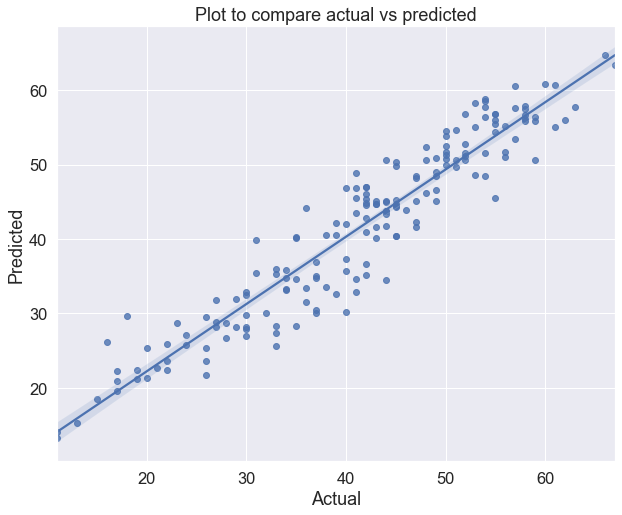

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

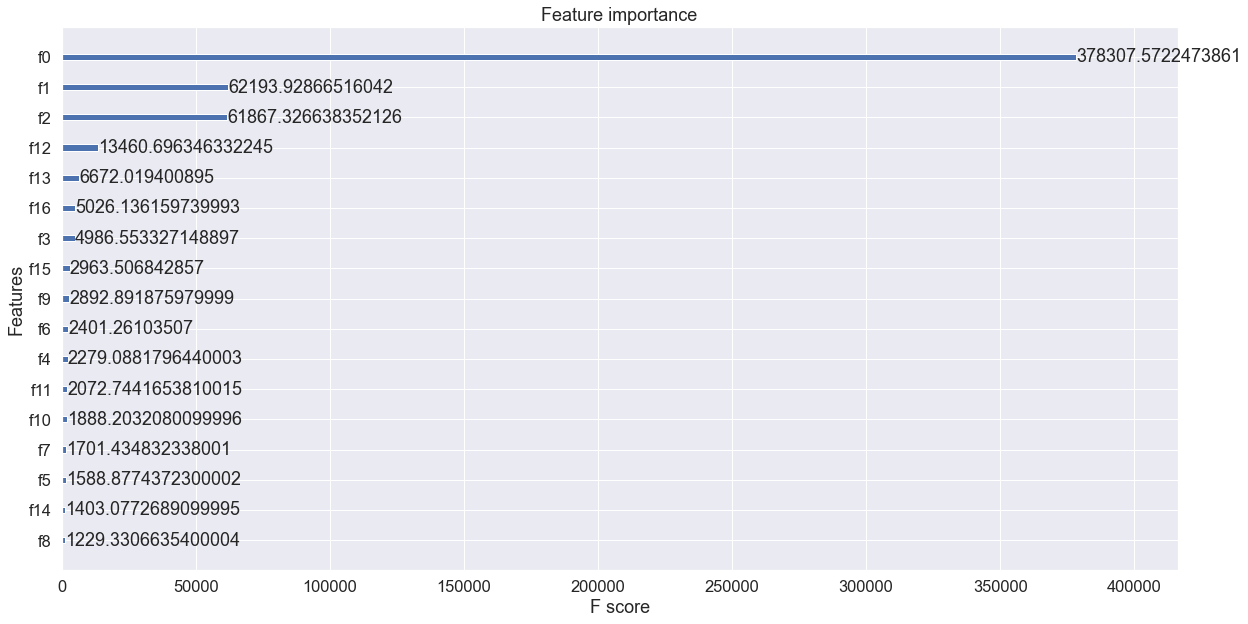

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgbmodel,ax=ax, importance_type='total_gain')
plt.show()

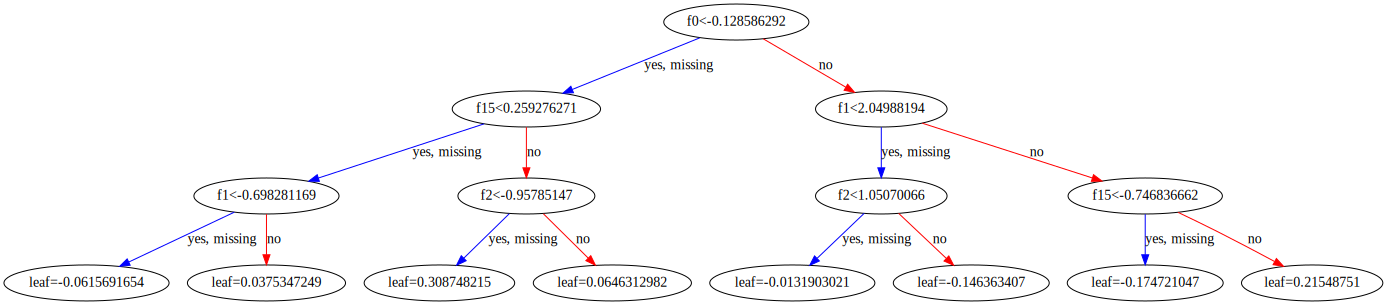

In [42]:
xgb.to_graphviz(xgbmodel,num_trees=100)

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [43]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished


In [44]:
cv.mean()

0.8588009216781156

In [45]:
model = XGBRegressor(random_state=0, n_estimators=400, objective='reg:squarederror')

In [46]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [47]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='r2')

In [48]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=400,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                           

In [49]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=0,
             importance_type='gain', learning rate=0.08, learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=900, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7, verbosity=1)

In [50]:
randm.best_score_

0.8614320756874181

In [51]:
randm.best_params_

{'subsample': 0.7,
 'n_estimators': 900,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning rate': 0.08,
 'gamma': 0,
 'colsample_bytree': 0.7999999999999999}